# Chatbot with Collection Schema 

## Review

Here, we'll show how to save semantic memories to a structured schema, a [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile). 

We introduced [Trustcall](https://github.com/hinthornw/trustcall), a library for reliably updating JSON schemas. 

We built a chatbot that saved memories to a single profile in response to a user provided keyword (`remember`)! 

## Goals

As discussed in the first lesson of this module, there are trade-offs with a single profile versus a collection of memories. 

Here we'll also show how to [save memories to a collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection), rather than a single schema. 

We'll also improve our chatbot by adding a tool that allows it to *decide when to save memories*, rather than relying on the user to explicitly tell it. 


In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall

In [17]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Defining a collection schema

Let's define a memory collection schema. 

In [ ]:
_set_env("OPENAI_API_KEY")

In [19]:
from pydantic import BaseModel, Field
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")
    context: str = Field(description="Additional context for the memory. For example: This was mentioned while discussing career options in Europe.")

In [20]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind Memory schema as a tool to the model
model_with_tools = model.bind_tools([Memory])

# Invoke the model with personal information, which should trigger the tool call
output = model_with_tools.invoke([HumanMessage("My name is Lance, I like to bike.")])
output.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_CeQntG0bzpybAK1D4tQNeWeB)
 Call ID: call_CeQntG0bzpybAK1D4tQNeWeB
  Args:
    content: User's name is Lance and he likes to bike.
    context: User introduction and personal interests.


## Chatbot with memory collection 

Before, we had a chatbot that saved memories to a single profile and based upon a user provided keyword (`remember`). 

Let's update this in two different ways: 

First, let's lets save memories with the above schema as a collection.

* For this, we'll simply define a `uuid` for each memory. 

Second, let's let the chatbot decide when to save memories. 

* The chatbot will perform tool calling when it decides to save a memory, as shown above.
* We'll create a `route_message` conditional edge that will look to see if the model makes a tool call.
* If it does, we'll route to a `store_memory` node that will save the memories into the Store. 


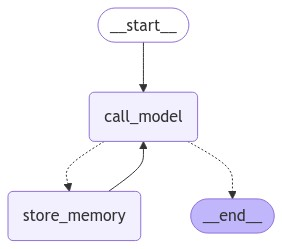

In [22]:
from IPython.display import Image, display

import uuid

from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Call the model with the system prompt that contains the memories as well as the user's messages."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"[{mem.key}]: {mem.value}" for mem in memories)
    system_msg = f"""You are a helpful assistant talking to the user.  
    Save any relevant information as a memory.
    Here are existing memories: {info}"""

    # Invoke the model with the system prompt that contains the memories as well as the user's messages
    response = model_with_tools.invoke([SystemMessage(content=system_msg)]+state["messages"])
    return {"messages": response}

def store_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Store the tool calls in the memory store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Generate a unique key for each memory
    key = str(uuid.uuid4())

    # Extract tool calls from the last message
    tool_calls = state['messages'][-1].tool_calls

    # Save each produced tool call schema to the store
    for tc in tool_calls:
        in_memory_store.put(namespace, key, tc["args"])

    # Create tool messages to confirm to the model that the tool calls were successful
    results = [
        ToolMessage(content=tc["args"], tool_call_id=tc["id"])
        for tc in tool_calls
    ]
    return {"messages": results}

def route_message(state: MessagesState):
    
    """Determine the next step based on the presence of tool calls."""

    # Get the last message from the user
    msg = state['messages'][-1]

    # If there are tool calls, we need to store memories
    if msg.tool_calls:
        return "store_memory"
    
    # Otherwise, finish; user can send the next message
    return END

# Define the graph
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(call_model)
builder.add_edge(START, "call_model")
builder.add_node(store_memory)
builder.add_conditional_edges("call_model", route_message, ["store_memory", END])
builder.add_edge("store_memory", "call_model")

# Store from cross-thread memory
in_memory_store = InMemoryStore()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=MemorySaver(), store=in_memory_store)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [23]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="Hi! My name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! My name is Lance
================================== Ai Message ==================================
Tool Calls:
  Memory (call_zGjBC3gvavQ9UBepnEDFIAlM)
 Call ID: call_zGjBC3gvavQ9UBepnEDFIAlM
  Args:
    content: User's name is Lance.
    context: User introduced themselves.
================================= Tool Message =================================

{'content': "User's name is Lance.", 'context': 'User introduced themselves.'}
================================== Ai Message ==================================

Hi Lance! How can I assist you today?


In [24]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Great! Today I biked in the morning in San Francisco.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great! Today I biked in the morning in San Francisco.
================================== Ai Message ==================================
Tool Calls:
  Memory (call_yMHKckpTbEEMMnMvNTSvrAzx)
 Call ID: call_yMHKckpTbEEMMnMvNTSvrAzx
  Args:
    content: User biked in the morning in San Francisco.
    context: User shared their morning activity.
================================= Tool Message =================================

{'content': 'User biked in the morning in San Francisco.', 'context': 'User shared their morning activity.'}
================================== Ai Message ==================================

That sounds like a refreshing way to start the day! How was your ride?


In [25]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, I went to the Marin headlands today.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, I went to the Marin headlands today.
================================== Ai Message ==================================
Tool Calls:
  Memory (call_tZbux2LoTeM8i1o1ot3fZ5FU)
 Call ID: call_tZbux2LoTeM8i1o1ot3fZ5FU
  Args:
    content: User biked to the Marin Headlands.
    context: User shared details about their biking route.
================================= Tool Message =================================

{'content': 'User biked to the Marin Headlands.', 'context': 'User shared details about their biking route.'}
================================== Ai Message ==================================

The Marin Headlands is such a beautiful area to bike through! How was the experience?


In [26]:
# Chat with the chatbot
input_messages = [HumanMessage(content="I like Miwok trail. Also, I like bakeries after biking.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like Miwok trail. Also, I like bakeries after biking.
================================== Ai Message ==================================
Tool Calls:
  Memory (call_lxmjVw5W4aNeHhOyv1MWW19G)
 Call ID: call_lxmjVw5W4aNeHhOyv1MWW19G
  Args:
    content: User likes the Miwok trail.
    context: User shared their preference for biking trails.
  Memory (call_8HotQtlTxfqiNw8bGH1mDBrv)
 Call ID: call_8HotQtlTxfqiNw8bGH1mDBrv
  Args:
    content: User likes visiting bakeries after biking.
    context: User shared their post-biking activity preference.
================================= Tool Message =================================

{'content': 'User likes visiting bakeries after biking.', 'context': 'User shared their post-biking activity preference.'}
================================== Ai Message ==================================

The Miwok Trail is a great choice for biking! And treating yourself to a visit to 

In [27]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in in_memory_store.search(("memories", user_id)):
    print(memory.value)

{'content': "User's name is Lance.", 'context': 'User introduced themselves.'}
{'content': 'User biked in the morning in San Francisco.', 'context': 'User shared their morning activity.'}
{'content': 'User biked to the Marin Headlands.', 'context': 'User shared details about their biking route.'}
{'content': 'User likes visiting bakeries after biking.', 'context': 'User shared their post-biking activity preference.'}


Now we can create a new thread and chat with the chatbot again.

It should retain the memories from the previous thread!

In [28]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="What bakeries would you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries would you recommend for me?
================================== Ai Message ==================================

Since you enjoy visiting bakeries after biking, especially in the San Francisco area, here are a few recommendations:

1. **Tartine Bakery** - Known for its delicious bread and pastries, it's a must-visit in San Francisco.
2. **B. Patisserie** - Offers a variety of French pastries, including their famous kouign-amann.
3. **Arizmendi Bakery** - A worker-owned cooperative bakery with a great selection of breads and pastries.
4. **Craftsman and Wolves** - Known for their inventive pastries and the "Rebel Within" muffin.
5. **Mr. Holmes Bakehouse** - Famous for their cruffins and other creative pastries.

These bakeries are popular and offer a range of delicious treats that you might enjoy after your biking adventures.


### LangSmith 

https://smith.langchain.com/public/1d1c129e-7e9f-4362-a96f-56b5955d8ab8/r

## Updating collection schema

Clearly, we can write to a collection of memories by giving each memory a unique key. 

In the last lesson, we discussed the challenge of updating a profile schema and introduced [Trustcall](https://github.com/hinthornw/trustcall) for this purpose. 

Now we'll show that [Trustcall](https://github.com/hinthornw/trustcall) can be also used to update a collection. 

This enables both addition of new memories as well as [updating existing memories in the collection](https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions
).

In [29]:
from trustcall import create_extractor

conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco."""

trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Instruction
instruction = f"""Extract memories from the following conversation:
<convo>
{conversation}
</convo>"""

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=instruction)]})
memories = result["responses"]
memories

memories[0].model_dump(mode="json")

{'content': 'User likes biking around San Francisco.',
 'context': 'User introduced themselves as Lance.'}

We simply pass any existing messages [here](https://github.com/langchain-ai/memory-template/blob/main/src/memory_graph/graph.py).

In [30]:
# Update the conversation
updated_conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco.
Assistant: San Francisco is a great city! Where do you go after biking?
User: I really like to go to a bakery."""

# Update the instruction
updated_instruction = f"""Reflect on following interaction. Use the provided tools to retain any necessary memories about the user. 
Use parallel tool calling to handle updates & insertions simultaneously:
<convo>
{updated_conversation}
</convo>"""

existing_memories = [(str(i), "Memory", memory.model_dump()) for i, memory in enumerate(memories)] if memories else None

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=updated_instruction)], 
                                     "existing": existing_memories})

updated_memories = result["responses"]
updated_memories

[Memory(content='User likes biking around San Francisco and visiting a bakery afterwards.', context='User introduced themselves as Lance.'),
 Memory(content='User likes to go to a bakery after biking.', context='This was mentioned during a conversation about biking in San Francisco.')]

We can see something very here. 

The metadata contains the `json_doc_id` for any *existing* memory that was updated. 

In [31]:
metadata = result["response_metadata"]
metadata

[{'id': 'call_8hLsZCKYIuQuaSsYri8vyyMT', 'json_doc_id': '0'},
 {'id': 'call_PSF1ZnAl2sNI6SeNZGv9ZQAm'}]

### LangSmith 

https://smith.langchain.com/public/ffd71309-71d9-4d82-babb-ebc273e726e4/r